<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP(TFID models)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import urllib
import time
import json

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
df= pd.read_csv('../data/coffee_tea.csv')
df.head()

,post,subreddit,post_len,word_count
0,"Voici un livre incroyable, qui vous fera gagne...",Coffee,648,45
1,Hey all o/\n\nMy wife is amazing at making cof...,Coffee,1332,243
2,So I've recently just started making my own co...,Coffee,228,40
3,"Hello all!\n\nI have been doing some research,...",Coffee,655,119
4,I’ve gotten pretty comfortable switching betwe...,Coffee,598,108


In [4]:
df.shape

(19592, 4)

In [13]:
X=df['post']
y=df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

pipe_1= Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegressionCV(solver='liblinear'))
])



In [14]:
pipe1_params= {
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,3000,4000,5000],
    'tvec__max_df':[.9, .95],
    'tvec__ngram_range':[(1,1),(1,2)]
}

In [15]:
gs1 = GridSearchCV(pipe_1, 
                  param_grid=pipe1_params,
                  cv = 5)

In [16]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logreg',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [17]:
gs1.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 4000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [18]:
preds_logreg=gs1.predict(X_test)

In [19]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9899959167006942, 0.967741935483871)

In [20]:
tn,fp, fn,tp = confusion_matrix(y_test,preds_logreg).ravel()

recall = tp/(tp+fn)
spec = tn/(tn+fp)
prec=tp/(tp+fp)
f1=2*(prec*recall)/(prec+recall)

print(f'F1 is : {f1}')
print(f'Sensitivity(recall) is : {recall}')
print(f'Specificity: {spec}')
print(f'Precision: {prec}')

F1 is : 0.9675431388660642
Sensitivity(recall) is : 0.9616169865251123
Specificity: 0.9738668844426297
Precision: 0.9735427862753204


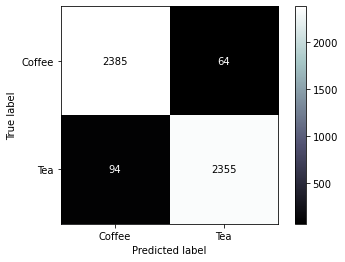

In [26]:
plot_confusion_matrix(gs1, X_test, y_test, cmap='bone', values_format='d');
plt.savefig('../images/tfidlr_conf_matrix.png')

In [21]:
type_I=1-spec
type_II=1-recall

print(f'Type I error is: {type_I}')
print(f'Type II error is: {type_II}')


Type I error is: 0.0261331155573703
Type II error is: 0.038383013474887706


### RandomForest TFID

In [28]:
pipe2= Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('rfc', RandomForestClassifier()),
])


In [30]:
rf_params={
    'tvec__min_df':[2,3],
    'tvec__max_features':[2000,3000,4000,5000],
    'tvec__max_df':[.9, .95],
    'tvec__ngram_range':[(1,1),(1,2)],
    'rfc__n_estimators':[100,150,200],
    'rfc__max_depth':[None, 1,2,3,4,5],
    'rfc__random_state':[42]
}

gsrf=GridSearchCV(pipe2,param_grid=rf_params,
                 cv=5,
                 n_jobs= 3)



In [31]:
gsrf.fit(X_train,y_train)

print(gsrf.best_score_)

gsrf.best_params_

/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9643394587147653


{'rfc__max_depth': None,
 'rfc__n_estimators': 200,
 'rfc__random_state': 42,
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [32]:
preds_rf=gsrf.predict(X_test)

In [33]:
gsrf.score(X_train, y_train), gsrf.score(X_test, y_test)

(0.9987750102082482, 0.9630461412821559)

In [34]:
tn,fp, fn,tp = confusion_matrix(y_test,preds_rf).ravel()

recall = tp/(tp+fn)
spec = tn/(tn+fp)
prec=tp/(tp+fp)
f1=2*(prec*recall)/(prec+recall)

print(f'F1 is : {f1}')
print(f'Sensitivity(recall) is : {recall}')
print(f'Specificity: {spec}')
print(f'Precision: {prec}')

F1 is : 0.9631289468323487
Sensitivity(recall) is : 0.9652919559003675
Specificity: 0.9608003266639444
Precision: 0.9609756097560975


In [35]:
type_I=1-spec
type_II=1-recall

print(f'Type I error is: {type_I}')
print(f'Type II error is: {type_II}')


Type I error is: 0.03919967333605556
Type II error is: 0.03470804409963246


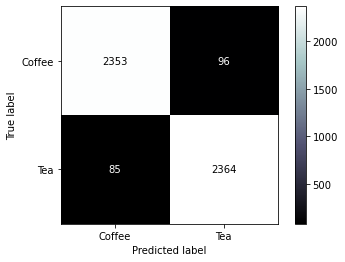

In [36]:
plot_confusion_matrix(gsrf, X_test, y_test, cmap='bone', values_format='d');
plt.savefig('../images/tfidrf_conf_matrix.png')

### Conclusion & Recommendations

Our client tasked us with finding some insights for them to help aid their sales strategies.  We were able to find some of the top word pairs for each particular subreddit and could gather some insight.  For the coffee subreddit we saw word pairs such as french press, espresso machine, cold brew, moka pot and coffee maker.  These are brewing methods that can help guide us into looking at more data. You can target the segment of customers by providing a variety of brewing methods at a coffee shop. Another way to approach it could be to sell this variety of equipment through all your sales channels(online, retail, etc.).  On the tea side of things you see the words centered around the variety of teas, green tea, black tea, loose lead, and oolong.  These conversations seem more centered around the plant themselves, a coffee/tea company may then want to examine their offerings in terms of quality and variety to target those customers.  The Logistic Regression here helps in that we can at least be assured that these word pairings are coming from the subreddit that they are predicted to come from.  We have a specificity score of 97.4% which tells us how well we predicted posts in the coffee subreddit. Our recall is 96.2% which is how well they predicted the posts in the tea subreddit.

### Next Steps

Of course we cannot just run with a recommendation without further information but there is something to this cultural difference between tea and coffee enthusiasts.  Looking at the company's sales data could also help us with regard to what features contribute to sales and how relevant the findings from this project are. We could improve the models by grid searching through more ngrams. Also, customizing the stop words in order to get rid of website hyperlinks and such.